In [1]:
import pandas as pd 
import wandb

api = wandb.Api()
entity, project = "jack-morris", "emb-inv-1"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

relevant_exp_names = ['mar17-baselines', 'mar19-random']
exp_runs = [run for run in runs if run.config.get('exp_group_name') in relevant_exp_names]

data = []
for run in exp_runs:
    summary = {k: v for k,v in run.summary.items() if not k.startswith('gradients/')}
    obj = {**run.config, **summary}
    data.append(obj)

df = pd.DataFrame(data)

In [2]:
# make new value for this experiment
from typing import Dict
def embedder_exp_str(row: Dict) -> str:
    # weird - have to compare to True value or else nan will eval to True
    if row['embedder_fake_with_zeros'] == True:
        return 'Unconditional'
    elif row['embedder_no_grad']:
        if row['embedder_model_name'] == 'gtr_base':
            return 'Reconstruct from embedding (GTR)'
        elif row['embedder_model_name'] == 'gtr_base__random_init':
            return 'Reconstruct from embedding (Random Transformer)'
        else: raise ValueError()
    else:
        return 'Input-conditioned (Autoencoder)'

df['embedder_exp'] = df.apply(embedder_exp_str, axis=1)

df.head()

,bf16,fp16,fsdp,seed,tf32,debug,optim,_n_gpu,do_eval,no_cuda,...,eval/steps_per_second,_step,eval/loss,_wandb,train/total_flos,train/train_loss,train/train_samples_per_second,train/train_runtime,train/train_steps_per_second,embedder_exp
0,True,False,,42,None,,adamw_hf,1,False,False,...,0.542,7504,1.415395,NaN,NaN,NaN,NaN,NaN,NaN,Reconstruct from embedding (Random Transformer)
1,True,False,,42,None,,adamw_hf,1,False,False,...,0.300,2861,2.474086,NaN,NaN,NaN,NaN,NaN,NaN,Reconstruct from embedding (Random Transformer)
2,True,False,,42,None,,adamw_hf,1,False,False,...,0.728,10474,0.405945,{'runtime': 139991},0.0,0.691536,914.503,139932.4187,7.144,Reconstruct from embedding (Random Transformer)
3,True,False,,42,None,,adamw_hf,1,False,False,...,0.409,5969,2.937458,NaN,NaN,NaN,NaN,NaN,NaN,Unconditional
4,True,False,,42,None,,adamw_hf,1,False,False,...,0.991,10474,3.282868,{'runtime': 182313},0.0,3.476624,702.122,182259.7754,5.485,Unconditional


In [3]:
import math

df['eval/bits_per_token'] = df['eval/perplexity'].apply(math.log2)
df['eval/bits'] = df['eval/bits_per_token'] * (df['max_seq_length'] - 1)

In [7]:
t5_vocab_size = 32128
t5_bits_per_token = math.log2(t5_vocab_size)
t5_bits_per_token

14.971543553950772

In [40]:
from typing import Dict

def make_theoretical_exp_row(msl: int) -> Dict:
    d = { 'max_seq_length': msl, 'embedder_exp': 'Theoretical max'}
    d['eval/bits'] = math.ceil(t5_bits_per_token * msl)
    d['eval/bits_per_token'] = t5_bits_per_token
    return d
    
theory_df = pd.DataFrame([
    make_theoretical_exp_row(msl) for msl in [8, 32, 128]
])
full_df = pd.concat((df, theory_df), axis=0)

In [41]:
full_df['embedder_exp'].unique()

array(['Reconstruct from embedding (Random Transformer)', 'Unconditional',
       'Reconstruct from embedding (GTR)',
       'Input-conditioned (Autoencoder)', 'Theoretical max'], dtype=object)

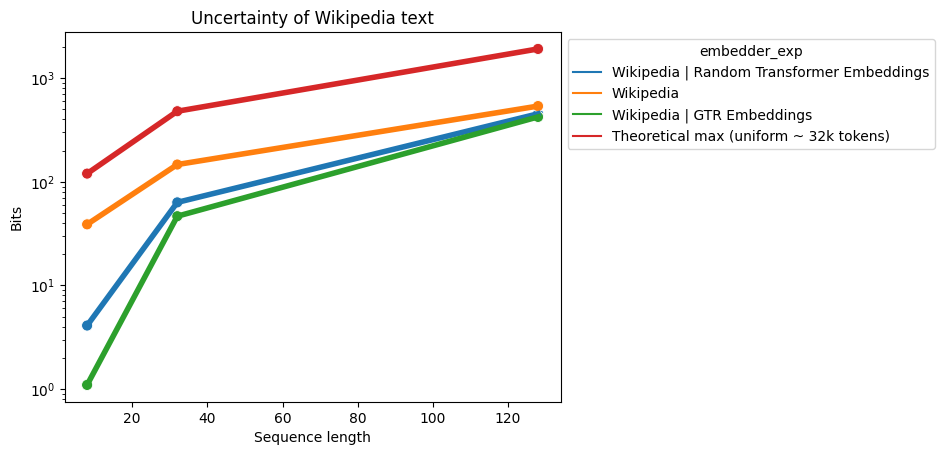

In [42]:
import seaborn as sns

plot_df = full_df[full_df['embedder_exp'].map(lambda s: 'Autoencoder' not in s)].reset_index()
EXP_RENAME = {
    'Theoretical max': 'Theoretical max (uniform ~ 32k tokens)',
    'Unconditional': 'Wikipedia',
    'Reconstruct from embedding (Random Transformer)': 'Wikipedia | Random Transformer Embeddings', 
    'Reconstruct from embedding (GTR)': 'Wikipedia | GTR Embeddings', 
    'Input-conditioned (Autoencoder)': 'Wikipedia | Optimal Embeddings',
}
plot_df['embedder_exp'] = plot_df['embedder_exp'].map(EXP_RENAME.get)


ax = sns.lineplot(
    data=plot_df, x='max_seq_length', y='eval/bits', 
    hue='embedder_exp', lw=4,
)
ax = sns.scatterplot(
    data=plot_df, x='max_seq_length', y='eval/bits', 
    hue='embedder_exp', s=64, legend=False,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits')
ax.set_yscale("log")
ax.set_title('Uncertainty of Wikipedia text')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

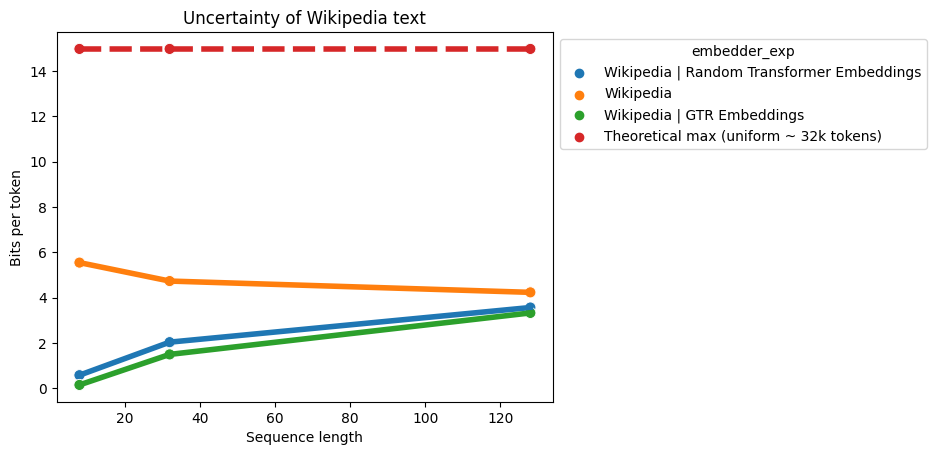

In [50]:
import seaborn as sns

plot_df = full_df[full_df['embedder_exp'].map(lambda s: 'Autoencoder' not in s)].reset_index()
EXP_RENAME = {
    'Theoretical max': 'Theoretical max (uniform ~ 32k tokens)',
    'Unconditional': 'Wikipedia',
    'Reconstruct from embedding (Random Transformer)': 'Wikipedia | Random Transformer Embeddings', 
    'Reconstruct from embedding (GTR)': 'Wikipedia | GTR Embeddings', 
    'Input-conditioned (Autoencoder)': 'Wikipedia | Optimal Embeddings',
}
plot_df['embedder_exp'] = plot_df['embedder_exp'].map(EXP_RENAME.get)
plot_df['is_theoretical'] = plot_df['embedder_exp'].map(lambda s: 'Theoretical' in s)


ax = sns.lineplot(
    data=plot_df, x='max_seq_length', y='eval/bits_per_token', 
    style='is_theoretical',
    hue='embedder_exp', lw=4, legend=False,
)
ax = sns.scatterplot(
    data=plot_df, x='max_seq_length', y='eval/bits_per_token', 
    hue='embedder_exp', s=64, legend=True,
)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Bits per token')
# ax.set_yscale("log")
ax.set_title('Uncertainty of Wikipedia text')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))